## Создать словарь данных, содержащихся в массиве показателей

In [88]:
import pandas as pd

# Импорт названий листов с данными
sheets = pd.read_csv('./data/sheets.txt', header=None).values.T[0].tolist()

# Импорт названий столбцов на соответствующих листах
sheets_columns = pd.read_csv('./data/sheets columns.txt', header=None, sep='\t').values

# Словарь-  лист: названия столбцов на листе
sname = dict((sheet,values.tolist()) for sheet,values in zip(sheets,sheets_columns))

### Загрузить и обработать данные

#### Импорт всех данных и обработка

In [108]:
# Все данные
earns = pd.read_csv('./data/earns.csv', low_memory=False)

# Убрать строки с неизвестными значениями по следующим столбцам
cols_isnan = [s for s in earns.columns if ('ActReportDate' in s) | ('ActValue' in s) | ('Mean' in s)]
earns = earns[~(earns[cols_isnan].isnull().all(axis=1))]

# Убрать .N в столбце тикеров
earns['Ticker'] = earns['Ticker'].str.replace('\.N','')

earns.shape

(39660, 202)

#### Данные по eps

In [116]:
eps = earns[sname['Earning Per Share']]

# Убрать неизвестные значения по всем столбцам
eps = eps[~eps.isnull().all(axis=1)]

# Убрать строки с неизвестными значениями по следующим столбцам
cols_isnan = [s for s in sname['Earning Per Share'] if ('ActReportDate' in s) | ('ActValue' in s) | ('Mean' in s)]
eps = eps[~(eps[cols_isnan].isnull().any(axis=1))]

# Даты объявления актуальноо показателя к виду datetime
eps['TR.EPSActReportDate'] = pd.to_datetime(eps['TR.EPSActReportDate'])

# Описательная статистика по eps
eps.describe()

,TR.EPSLow,TR.EPSHigh,TR.EPSMean,TR.EPSMedian,TR.EPSStdDev,TR.EPSNumberOfEstimates,TR.EPSSmartEst,TR.EPSActValue,TR.EPSActSurprise
count,37977.000000,37977.000000,37977.000000,37977.000000,37977.000000,37977.000000,18299.000000,37977.000000,37877.000000
mean,1.839006,2.317515,2.067609,2.057529,0.166610,10.512336,2.075826,2.074330,1.965075
std,58.865762,65.915231,62.226852,61.996419,3.590923,7.487154,71.131351,62.100513,658.904235
min,-877.944000,-775.327170,-820.507080,-823.785120,0.000000,1.000000,-829.805300,-1088.878600,-55895.455000
25%,0.110000,0.200000,0.159330,0.160000,0.013090,5.000000,0.148915,0.151550,-4.984000
50%,0.350000,0.460000,0.404300,0.400000,0.027140,9.000000,0.407520,0.420000,3.759000
75%,0.680000,0.850000,0.758670,0.760000,0.056740,15.000000,0.780505,0.800000,16.505000
max,2910.000000,3226.730000,3041.843350,3074.000000,245.261700,43.000000,3055.207610,2951.000000,26226.126000


# Импорт исторических данных

In [167]:
# Загрузить исторические данные
close_adj = pd.read_csv('./data/close_adj.csv', index_col=0, parse_dates=[0])
close_unadj = pd.read_csv('./data/close_unadj.csv', index_col=0, parse_dates=[0])
open_unadj = pd.read_csv('./data/open_unadj.csv', index_col=0, parse_dates=[0])

# Матрицы цен до и после объявления показателя

#### Удалить строки с акциями, по которым событие выходит во время сессии

In [6]:
# акции, по которым информация выходила во время сессии
in_session =  ~((eps['TR.EPSActReportDate'].dt.hour==9) & (eps['TR.EPSActReportDate'].dt.minute<30) | \
    (eps['TR.EPSActReportDate'].dt.hour<9) | (eps['TR.EPSActReportDate'].dt.hour>=16))

# Удалить акции с показателями вышедшими во время сессии
eps = eps[~in_session]

#### Индексы строк выходом актуального значения до и после сессии

In [7]:
# Информация до сессии
before = (eps['TR.EPSActReportDate'].dt.hour==9) & (eps['TR.EPSActReportDate'].dt.minute<30) | \
    (eps['TR.EPSActReportDate'].dt.hour<9)

# Информация после сессии
after = eps['TR.EPSActReportDate'].dt.hour>=16

#### Создать вектор дат события
Вектор дат события - это дата, когда объявлен показатель. Сессия в эту дату начинает торговаться с уже известной информацией по рассматриваемому показателю.

In [8]:
from pandas.tseries.offsets import BDay

# Создать вектор дат для каждого тикера, где дата - старт второго окна days_after
date_delim = eps['TR.EPSActReportDate'].copy()

# Что выходит до сессии - оставляем текущий день (дальше взять Open Этого дня)

# Что выходит после сессии - следующий рабочий день (дальше взять Open этого дня)
date_delim[after] = date_delim[after] + BDay()

# Оставить только дату без времени
date_delim = date_delim.dt.normalize()

### Функция создания цен вокруг события
- prices - массив исторических цен
- date_delim - день, сессия в котором начинается после выхода события
- num_days - Количество дней, для которых создать цены. Со знаком минус - цены до события, со знаком плюс - цены после события.
- tickers - вектор тикеров (=eps['Ticker'])

In [299]:
import numpy as np

def create_event_prices(prices, date_delim,  num_days, tickers):
    
    # Преаллокация массива для цен вокруг события
    event_data = np.empty((date_delim.shape[0], abs(num_days)))
    event_data[:]=np.nan
    
    # Отсутствующие тикеры в массиве цен
    no_tickers_price = []

    for rr in range(edata_before.shape[0]):
        try:
            # Индексы цен до события или после события
            if num_days<0:
                idx = prices.index<date_delim.iloc[rr]
            elif num_days>0:
                idx = prices.index>=date_delim.iloc[rr]
            
            # Цены до или после события
            price_event = prices[tickers.iloc[rr]][idx]
            
            # Удалить неизвестные цены если есть
            price_event = price_event[~price_event.isnull()].values

            # Проверить количество доступных цен до события
            num_prices = min(price_event.shape[0], abs(num_days))

            # Заполнить
            if num_days<0:
                event_data[rr][abs(num_days)-num_prices:abs(num_days)] = price_event[num_days:]
            elif num_days>0:
                event_data[rr][:num_prices] = price_event[:num_days]
        except:
            # Записать тикер для которого не найдены цены в массиве цен
            no_tickers_price.append(tickers.iloc[rr])
    
    print('No files history for:', set(no_tickers_price))
    
    return event_data

### Создать массивы цен вокруг события

#### Задание количества дней вокруг события

In [ ]:
# Количество дней до выхода отчета
days_before = 40 +1

# Количество дней после выхода отчета
days_after = 20 +1

#### Цены adjusted

In [300]:
# Цены до выхода события
edata_before_adj = create_event_prices(close_adj, date_delim, -days_before, eps['Ticker'])

# Цены после события
edata_after_adj = create_event_prices(close_adj, date_delim, days_after, eps['Ticker'])

# Объединенные цены
edata_all_adj = np.concatenate([edata_before_adj, edata_after_adj], axis=1)


No files history for: {'FCEa', 'BFb', 'JWa', 'BRKa', 'NYLDa', 'LGFa'}
No files history for: {'FCEa', 'BFb', 'JWa', 'BRKa', 'NYLDa', 'LGFa'}


#### Цены unadjusted + open в день события

In [302]:
# Цены до выхода события
edata_before = create_event_prices(close_unadj, date_delim, -days_before, eps['Ticker'])

# Цены после события
edata_after = create_event_prices(close_unadj, date_delim, days_after, eps['Ticker'])

# Цены Open в день выхода события
edata_open = create_event_prices(open_unadj, date_delim, 1, eps['Ticker'])

# Объединенные цены
edata_all = np.concatenate([edata_before, edata_open, edata_after], axis=1)

No files history for: {'FCEa', 'BFb', 'JWa', 'BRKa', 'NYLDa', 'LGFa'}
No files history for: {'FCEa', 'BFb', 'JWa', 'BRKa', 'NYLDa', 'LGFa'}
No files history for: {'FCEa', 'BFb', 'JWa', 'BRKa', 'NYLDa', 'LGFa'}


### Логарифмические и куммулятивные доходности

In [316]:
# Логарифмические доходности
logret_before = np.log((edata_before[:,1:]/edata_before[:,:-1]))
logret_after = np.log((edata_after[:,1:]/edata_after[:,:-1]))
logret_all = np.log((edata_all[:,1:]/edata_all[:,:-1]))

# Куммулятивные доходности
logret_before_cum = np.cumsum(logret_before, axis=1)
logret_after_cum = np.cumsum(logret_after, axis=1)
logret_all_cum = np.cumsum(logret_all, axis=1)

### Изменение наблюдаемого показателя

In [150]:
# Разница актуального с ожидаемым
shock_dif = (eps['TR.EPSActValue'] - eps['TR.EPSMean'])

# Построение графики

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline
import  seaborn as sns

# настройка внешнего вида графиков в seaborn
#sns.set_style("dark")
sns.set(style="white")
sns.set_palette("RdBu")
sns.set_color_codes("muted")
sns.set_context("notebook", font_scale = 1.5, rc = { "figure.figsize" : (18, 8), "axes.titlesize" : 18 })

### Функция для отрисовки графика ACAR

In [323]:
def plot_acar(logret_all_cum, filter_, days_before, days_after):
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(np.arange(-days_before+1, logret_all_cum.shape[1]-days_before+1), np.nanmean(logret_all_cum[filter_], axis=0), color="#6A1B9A", label='ACAR')
    ax.axvline(-1, color='blue', linewidth=0.8, linestyle=':', label='Event line')
    ax.set_xlabel('День наблюдения')
    ax.set_ylabel('ACAR')
    ax.grid(linestyle=':')
    ax.legend();

    print('Наблюдений:', sum(filter_))

## ACAR для различных ситуаций

### Показатель объявлен выше ожидаемого значения

Наблюдений: 22617


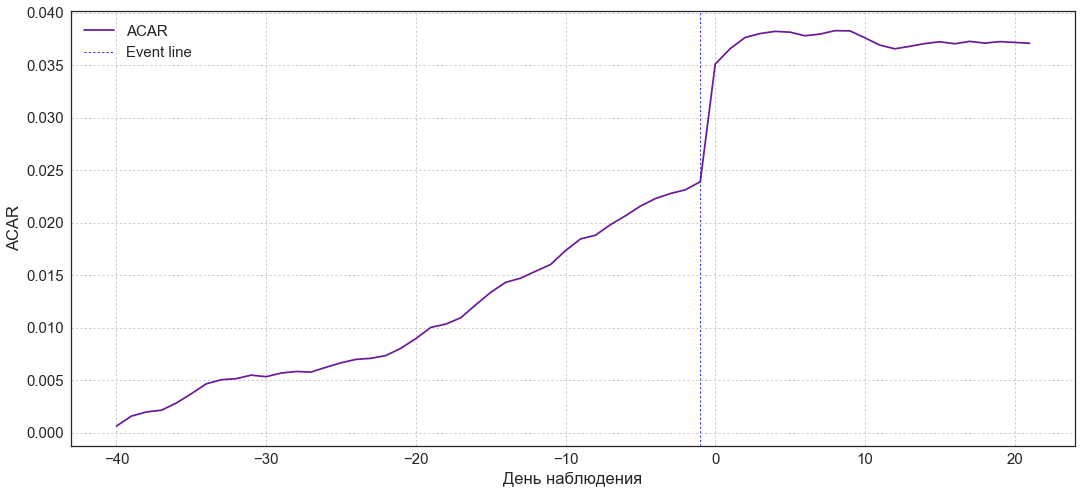

In [325]:
filter_ = shock_dif>0
plot_acar(logret_all_cum, filter_, days_before, days_after)

### Показатель объявлен ниже ожидаемого значения

Наблюдений: 13947


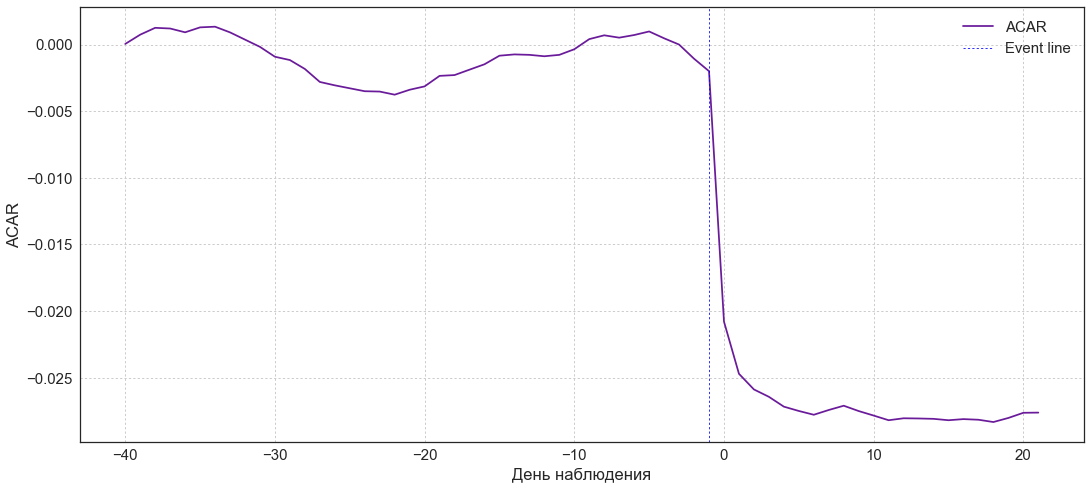

In [326]:
filter_ = shock_dif<0
plot_acar(logret_all_cum, filter_, days_before, days_after)

### Ждали отрицательный - объявили положительный

Наблюдений: 660


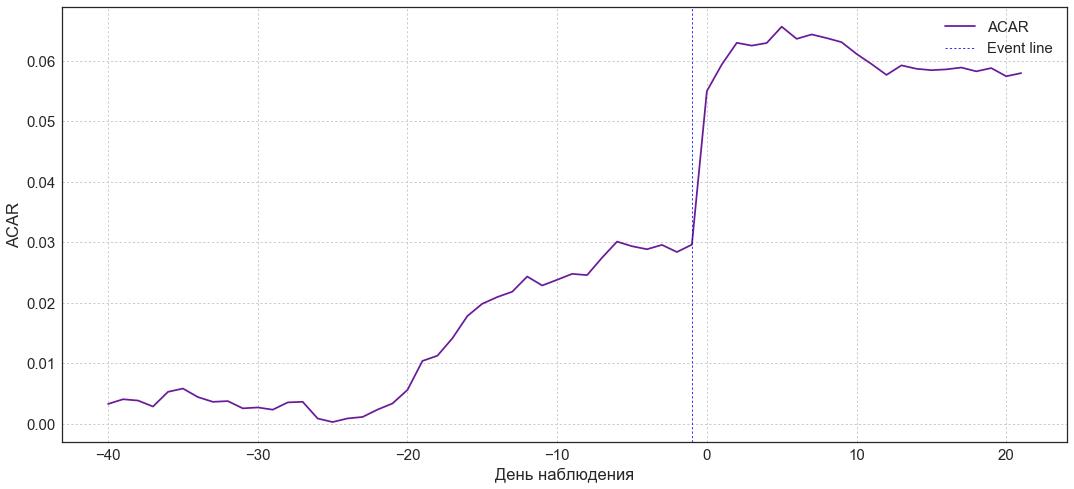

In [327]:
filter_ = (eps['TR.EPSMean']<0) & (eps['TR.EPSActValue']>0)
plot_acar(logret_all_cum, filter_, days_before, days_after)

### Ждали положительный - объявили отрицательный

Наблюдений: 1008


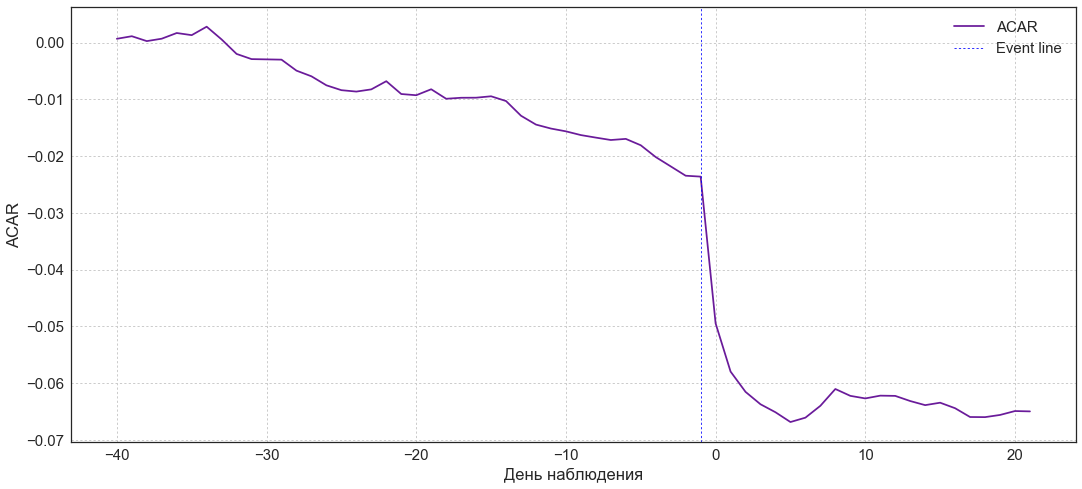

In [328]:
filter_ = (eps['TR.EPSMean']>0) & (eps['TR.EPSActValue']<0)
plot_acar(logret_all_cum, filter_, days_before, days_after)